In [65]:
import sys
import os
from sam2 import sam2_image_predictor
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import math
import io
import base64
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [66]:
def add_grid_to_image(image_path, show_image=True):
    # Open the image
    img = Image.open(image_path)

    # Get image dimensions
    img_width, img_height = img.size

    # Calculate number of grid lines
    num_lines_x = math.ceil(img_width / 50)
    num_lines_y = math.ceil(img_height / 50)

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))

    # Display the image
    ax.imshow(img)

    # Set up the grid
    ax.set_xticks(np.arange(0, img_width, 50))
    ax.set_yticks(np.arange(0, img_height, 50))

    # Add gridlines
    ax.grid(color='blue', linestyle=(0, (5, 10)), linewidth=1)

    # Set axis labels
    ax.set_xlabel('X-axis (pixels)')
    ax.set_ylabel('Y-axis (pixels)')

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

    # Add numerical labels
    ax.set_xticks(np.linspace(0, img_width, num_lines_x + 1))
    ax.set_yticks(np.linspace(0, img_height, num_lines_y + 1))

    plt.title('Image with Labeled Grid Overlay')
    plt.tight_layout()

    # Save the figure to a BytesIO object

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Convert the BytesIO object to base64
    base64_str = base64.b64encode(buf.getvalue()).decode('utf-8')

    # Close the figure to free up memory

    return base64_str

In [104]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    if box.ndim == 1:  # Single box
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    elif box.ndim == 2:  # Multiple boxes
        for b in box:
            x0, y0 = b[0], b[1]
            w, h = b[2] - b[0], b[3] - b[1]
            ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    else:
        raise ValueError("Invalid box dimensions. Expected 1D or 2D array.")

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

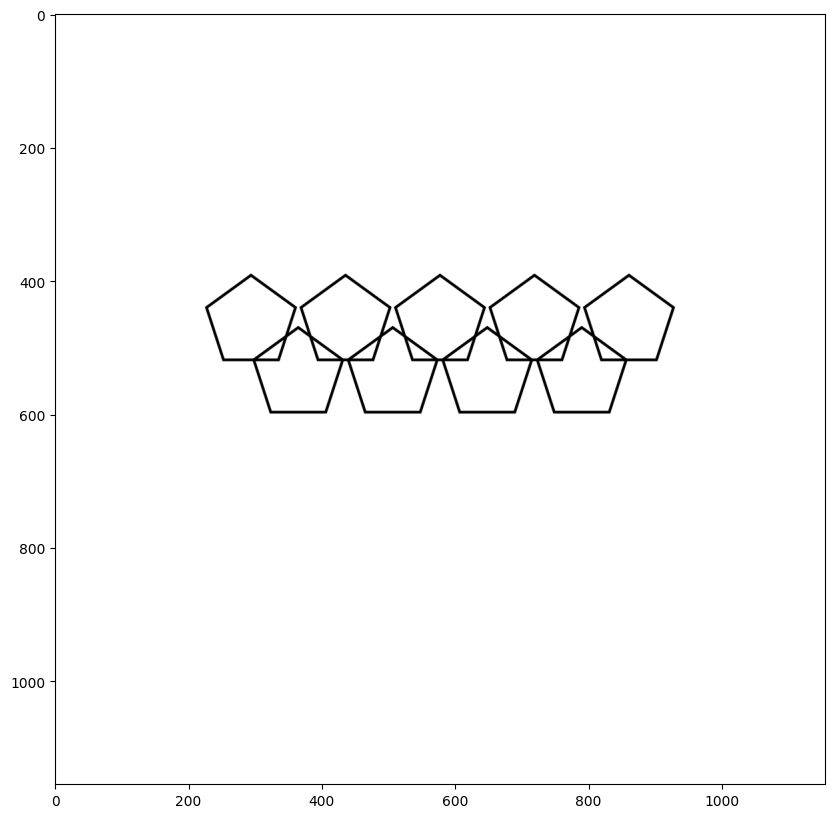

In [124]:
image = Image.open('images/lottapentagon.png')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

device = torch.device("cpu")
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

In [143]:
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import io
# import base64

def show_mask_with_grid(mask, ax, random_color=False, borders=True, grid_interval=50):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 1])
    
    # Set mask to be white
    # color = np.array([1,1,1,1])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)
    
    # Add grid
    ax.set_xticks(np.arange(0, w, grid_interval))
    ax.set_yticks(np.arange(0, h, grid_interval))
    ax.grid(color='blue', linestyle=(0, (5, 10)), linewidth=1)
    
    # Set axis labels
    ax.set_xlabel('X-axis (pixels)')
    ax.set_ylabel('Y-axis (pixels)')
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
    
    # Add numerical labels
    ax.set_xticks(np.arange(0, w, grid_interval))
    ax.set_yticks(np.arange(0, h, grid_interval))
    
    ax.set_xticklabels(np.arange(0, w, grid_interval))
    ax.set_yticklabels(np.arange(0, h, grid_interval))

# def show_masks_with_grid(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
#     for i, (mask, score) in enumerate(zip(masks, scores)):
#         # fig, ax = plt.subplots(figsize=(10, 10))
#         # ax.imshow(image)
#         plt.figure(figsize=(10,10))
#         plt.imshow(image)
#         show_mask_with_grid(mask, plt.gca(), borders=borders)
#         if point_coords is not None:
#             assert input_labels is not None
#             show_points(point_coords, input_labels, plt.gca())
#         if box_coords is not None:
#             show_box(box_coords, plt.gca())
#         # if len(scores) > 1:
#         #     ax.set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#         plt.axis('on')  # Changed to 'on' to show the grid
#         plt.show()

# The rest of your functions (show_points, show_box) remain unchanged

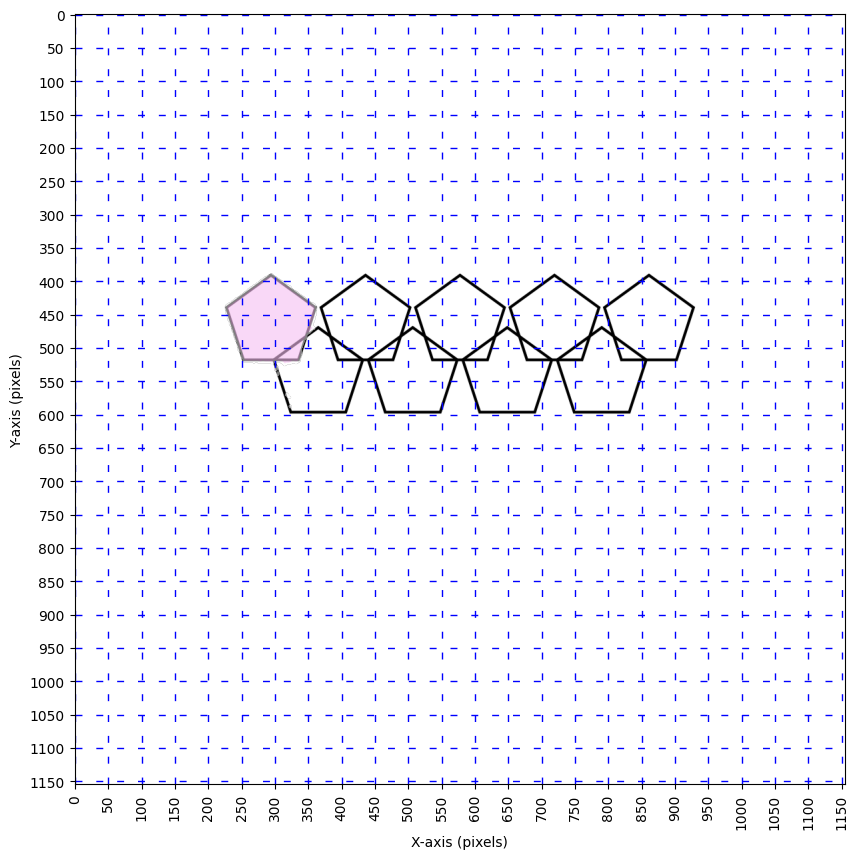

In [144]:
input_boxes = np.array([240, 385, 385, 578])
# box2 = np.array([385, 385, 530, 580])
# box3 = np.array([300, 450, 500, 625])
# box4 = np.array([400, 450, 600, 625])
# box5 = np.array([485, 385, 650, 578])

# input_boxes = np.vstack((input_boxes, box2))
# input_boxes = np.vstack((input_boxes, box3))
# input_boxes = np.vstack((input_boxes, box4))
# input_boxes = np.vstack((input_boxes, box5))

input_point = np.array([[100, 100]])
input_label = np.array([0])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# for mask in masks:
#     show_mask(mask.squeeze(0), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box, plt.gca())
# plt.axis('off')
# plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    # show_mask_with_grid(mask.squeeze(0), plt.gca(), random_color=True)
    show_mask_with_grid(mask, plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box, plt.gca())
plt.axis('on')
plt.show()


In [139]:
white_mask = np.ones_like(image) * 255  # Set all pixels to white

# Create a combined mask
combined_mask = np.zeros(masks[0].shape[1:], dtype=bool)

# Combine all masks
for mask in masks:
    # combined_mask |= mask.squeeze(0).astype(bool)
    combined_mask |= mask.astype(bool)

plt.figure(figsize=(10, 10))

# Apply the white mask where the combined mask is True
masked_image = np.where(combined_mask[:, :, None], white_mask, image)

# Display the masked image
plt.imshow(masked_image)

# for box in input_boxes:
#     show_box(box, plt.gca())

plt.axis('off')
plt.show()

ValueError: non-broadcastable output operand with shape (1155,) doesn't match the broadcast shape (1155,1155)

In [138]:
if image.shape[2] == 3:
    image_rgba = np.concatenate([image, np.ones((*image.shape[:2], 1)) * 255], axis=2)
else:
    image_rgba = image.copy()

# Create a combined mask
combined_mask = np.zeros(masks[0].shape[1:], dtype=bool)
for mask in masks:
    combined_mask |= mask.squeeze(0).astype(bool)

# Make the masked areas transparent
image_rgba[combined_mask, 3] = 0

# Create a checkered background
x, y = np.meshgrid(range(image_rgba.shape[1]), range(image_rgba.shape[0]))
checkered = (x + y) % 2 == 0
checkered_bg = np.stack([checkered * 200, checkered * 200, checkered * 200, np.ones_like(checkered) * 255], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(checkered_bg)
plt.imshow(image_rgba)

for box in input_boxes:
    show_box(box, plt.gca())

plt.axis('off')
plt.show()

ValueError: non-broadcastable output operand with shape (1155,) doesn't match the broadcast shape (1155,1155)